<a href="https://colab.research.google.com/github/neurologic/Neurophysiology-Lab/blob/main/week-5/Sensory-Coding-MRO.ipynb" target="_blank" rel="noopener noreferrer"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   

<a id="toc"></a>
# Table of Contents

- [Introduction](#intro)
- [Setup](#setup)
- [Event Detection](#one)
- [Trial-Based Analysis](#two)


<a id="intro"></a>
# Sensory Coding - MROs

There are two MROs innervating the deep flexor muscles, which can be distinguished based on spike height and shape. 

What are the dynamic properties of MRO sensory responses? In this notebook, you will process, analyze, and model MRO sensory responses.

<a id="setup"></a>
# Setup

[toc](#toc)

Import and define functions

In [2]:
#@title {display-mode: "form" }

#@markdown Run this code cell to import packages and define functions 
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import ndimage
from scipy.signal import hilbert,medfilt,resample, find_peaks, unit_impulse
import seaborn as sns
from datetime import datetime,timezone,timedelta
pal = sns.color_palette(n_colors=15)
pal = pal.as_hex()
import matplotlib.pyplot as plt
import random

from pathlib import Path

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from ipywidgets import widgets, interact
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

Task completed at 2022-08-26 19:34:51.407427-05:00


Mount Google Drive

In [ ]:
#@title {display-mode: "form" }

#@markdown Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount('/content/drive')

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

## Import data 

Import data digitized with *Nidaq USB6211* and recorded using *Bonsai-rx* as a *.bin* file

If you would like sample this Data Explorer, but do not have data, you can download [an example of an increasing step protocol](https://drive.google.com/file/d/1mB2hO60z0HTRsh-IsMOvaCz8YvHGPWoO/view?usp=sharing), [an example of a regular step (variable baseline) protocol](https://drive.google.com/file/d/1B1AdQyUyn-Tu5UAnpxYy9_qodpJzmgPj/view?usp=sharing) and [an example of a continuous bend protocol](https://drive.google.com/file/d/10ZVqZvj8SNA7WEhWmf-yVgn86TqTSJbq/view?usp=sharing). After downloading, you can upload the file directly to Google Colab (or access the file through Drive after uploading it to your Drive). If you are using this example file, the sample rate was 30000 on two channels (channel 0 was the MRO signal and channel 1 was the stimulus monitor). The stimulus is a PWM signal to a servo motor to bend the tail. The recording was taken with the photographed preparation in the lab manual. 

In [3]:
#@title {display-mode: "form" }

#@markdown Specify the file path 
#@markdown to your recorded data on Drive (find the filepath in the colab file manager:

filepath = "full filepath goes here"  #@param 
filepath = '/Volumes/Untitled 1/BIOL247/data/crayfish-mro/mro_steps_0.bin'  #@param 

#@markdown Specify the sampling rate and number of channels recorded.

sampling_rate = 30000 #@param
number_channels = 2 #@param

downsample = False #@param
newfs = 10000 #@param

#@markdown After you have filled out all form fields, 
#@markdown run this code cell to load the data. 

filepath = Path(filepath)

# No need to edit below this line
#################################
data = np.fromfile(Path(filepath), dtype = np.float64)
data = data.reshape(-1,number_channels)
data_dur = np.shape(data)[0]/sampling_rate
print('duration of recording was %0.2f seconds' %data_dur)

fs = sampling_rate
if downsample:
    # newfs = 10000 #downsample emg data
    chunksize = int(sampling_rate/newfs)
    data = data[0::chunksize,:]
    fs = int(np.shape(data)[0]/data_dur)

time = np.linspace(0,data_dur,np.shape(data)[0])

print('Data upload completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

duration of recording was 301.50 seconds
Data upload completed at 2022-08-26 19:34:56.448644-05:00


In [4]:
#@title {display-mode: "form"}

#@markdown Run this code cell to plot imported data. <br> 
#@markdown Use the range slider to scroll through the data in time.
#@markdown Use the channel slider to choose which channel to plot
#@markdown Be patient with the range refresh... the more data you are plotting the slower it will be. 

slider_xrange = widgets.FloatRangeSlider(
    min=0,
    max=data_dur,
    value=(0,1),
    step= 1,
    readout=True,
    continuous_update=False,
    description='Time Range (s)')
slider_xrange.layout.width = '600px'

slider_chan = widgets.IntSlider(
    min=0,
    max=number_channels-1,
    value=0,
    step= 1,
    continuous_update=False,
    description='channel')
slider_chan.layout.width = '300px'

# a function that will modify the xaxis range
def update_plot(x,chan):
    fig, ax = plt.subplots(figsize=(10,5),num=1); #specify figure number so that it does not keep creating new ones
    starti = int(x[0]*fs)
    stopi = int(x[1]*fs)
    ax.plot(time[starti:stopi], data[starti:stopi,chan])

w = interact(update_plot, x=slider_xrange, chan=slider_chan);

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), continuous_update=False, description='Time Range (s)'…

For a more extensive ***RAW*** Data Explorer than the one provided in the above figure, use the [DataExplorer.py](https://raw.githubusercontent.com/neurologic/Neurophysiology-Lab/main/howto/Data-Explorer.py) application found in the [howto section](https://neurologic.github.io/Neurophysiology-Lab/howto/Dash-Data-Explorer.html) of the course website.

<a id="one"></a>
# Part I. Event Detection

Python has built-in algorithms for detecting "peaks" in a signal. However, it will detect *all* peaks. Therefore, the function takes in arguments that specify parameters for minimum height that can count as a peak and a minimum acceptible interval between independent peaks. 

First, we will detect all the peaks on the MRO nerve channel. This will give the time of each *peak above threshold* (putative MRO spikes).  

In [5]:
#@title {display-mode: "form"}

#@markdown Fill in this form. Decide on the peak detection threshold. 
#@markdown Choose which channel you want to use for event detection.
#@markdown Indicate the polarity of the threshold: upward (1) or downward (-1) peaks

channel = 0 #@param
detection_threshold = 0.3 #@param
polarity = 1 #@param

#@markdown Then, run the code cell to detect peaks (events) and plot the signal
#@markdown overlaid with a scatter of trial times detected using your threshold. 

d = 0.0003*fs #minimum time allowed between distinct events
r = find_peaks(data[:,channel]*polarity,height=detection_threshold*polarity,distance=d)

trial_times = r[0]/fs
event_amp = r[1]['peak_heights']
    
slider = widgets.FloatRangeSlider(
    min=0,
    max=data_dur,
    value=(0,1),
    step= 0.5,
    readout=False,
    continuous_update=False,
    description='Time Range (s)')
slider.layout.width = '800px'

# a function that will modify the xaxis range
def update_plot(x):
    fig, ax = plt.subplots(figsize=(10,5),num=1); #specify figure number so that it does not keep creating new ones
    starti = int(x[0]*fs)
    stopi = int(x[1]*fs)
    ax.plot(time[starti:stopi], data[starti:stopi,channel])
    ax.scatter(trial_times[(trial_times>x[0]) & (trial_times<x[1])],
               [np.median(data[:,channel])] * len(trial_times[(trial_times>x[0]) & (trial_times<x[1])]),
              zorder=3,color='black',s=50)

w = interact(update_plot, x=slider);

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), continuous_update=False, description='Time Range (s)'…

Once you know the times of each peak (each event), we can look at the signal triggered off of those events. To do this, we plot the signal at the event time and some duration before and after that peak. 

> Note: If you do not think you are detecting enough of the events or if you think you are detecting too much noise, modify your detection threshold and go through the detection steps in Part I again.

<a id="two"></a>
# Part II. Stimulus Processing

A servo motor is controlled by a [*pulse width modulated*](https://learn.sparkfun.com/tutorials/pulse-width-modulation/all) signal. To get a continuous readout of the position command to the servo motor, we need to process the stimulus monitor signal. 

In [45]:
w = 700
pwm = np.convolve(data[:,channel_], np.ones(w)/w, mode='full')

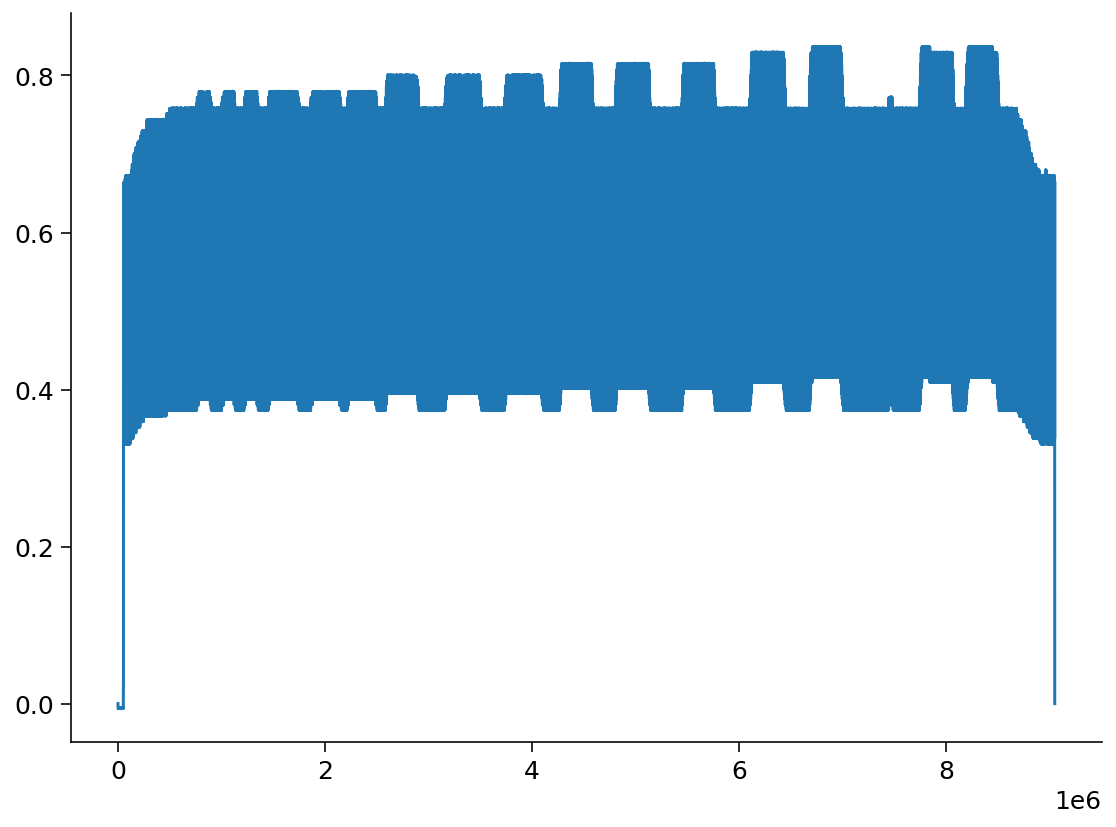

In [46]:
plt.plot(pwm)

<a id="thress"></a>
# Part III. Trial-Based Analysis

In [ ]:
#@title {display-mode: "form"}

#@markdown Run this cell to create an interactive plot with a slider to scroll 
#@markdown through data on each channel for individual trials.
#@markdown The stimulus amplitude will be printed for each trial. 

slider_xrange = widgets.FloatSlider(
    min=2,
    max=40,
    value=10,
    step=0.5,
    continuous_update=False,
    readout=False,
    description='xrange (ms)'
)
slider_xrange.layout.width = '600px'

slider_yrange = widgets.FloatRangeSlider(
    min=np.min(np.min(data)),
    max=np.max(np.max(data)),
    value=[np.min(np.min(data)),np.max(np.max(data))],
    step=0.01,
    continuous_update=False,
    readout=False,
    description='yrange'
)
slider_yrange.layout.width = '600px'

slider_trial = widgets.IntSlider(
    min=0,
    max=len(trial_times)-1,
    value=0,
    step= 1,
    continuous_update=False,
    readout=False,
    description='trial')
slider_trial.layout.width = '600px'

slider_chan = widgets.IntSlider(
    min=0,
    max=number_channels-1,
    value=0,
    step= 1,
    continuous_update=False,
    readout=False,
    description='channel')
slider_chan.layout.width = '300px'

label_eventamp = widgets.Label(
    value='stimulus amplitude'
)
label_eventamp.layout.width = '300px'
display(label_eventamp)

# a function that will modify the xaxis range
def update_plot(trial_,chan,xrange,yrange):
    fig, ax = plt.subplots(figsize=(10,5),num=1); #specify figure number so that it does not keep creating new ones
    
    offset_ = 1
    win_0 = int(offset_/1000*fs)
    win_1 = int(xrange/1000*fs)

    events = np.asarray([data[(int(fs*t)-win_0):(int(fs*t)+win_1),chan] for t in trial_times 
          if (((int(fs*t)-win_0)>0) & ((int(fs*t)+win_1)<np.shape(data)[0]))]).T
    xtime = np.linspace(-offset_,xrange,(win_0 + win_1))

    ax.plot(xtime,events[:,trial_],color='black',linewidth=3)
    ax.set_ylim(yrange[0],yrange[1]);
    ax.set_xlabel('milliseconds')
    
    # Change major ticks to show every 20.
    ax.xaxis.set_major_locator(MultipleLocator(5))
    # ax.yaxis.set_major_locator(MultipleLocator(20))

    # Change minor ticks to show every 5. (20/4 = 5)
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    # Turn grid on for both major and minor ticks and style minor slightly
    # differently.
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle=':')

    # print(f'stimulus monitor peak = {event_amp[trial_]}')
    label_eventamp.value = 'peak amplitude = ' + str(np.round(event_amp[trial_],4)) + ' Volts'

w = interact(update_plot, trial_=slider_trial, chan=slider_chan, xrange=slider_xrange, yrange=slider_yrange);

<a id="toc"></a>
# Table of Contents

- [Introduction](#intro)
- [Setup](#setup)
- [Part I. Process Data](#one)
- [Part II. Analyze Processed Data](#two)


<a id="setup"></a>
# Setup

[toc](#toc)

Import and define functions

In [ ]:
#@title {display-mode: "form"}

#@markdown Run this code cell to import packages and define functions 
from pathlib import Path
import random
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import ndimage, optimize
from scipy.signal import hilbert,medfilt,resample, find_peaks
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from datetime import datetime,timezone,timedelta
pal = sns.color_palette(n_colors=15)
pal = pal.as_hex()

from ipywidgets import interactive, HBox, VBox, widgets, interact

def monoExp(x, m, t, b):
    return m * np.exp(-x / t) + b

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

Mount Google Drive

In [ ]:
#@title {display-mode: "form"}

#@markdown Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount('/content/drive')

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

Import data digitized with *Nidaq USB6211* and recorded using *Bonsai-rx* as a *.bin* file

In [ ]:
#@title {display-mode: "form"}

#@markdown Specify the file path 
#@markdown to your recorded data on Drive (find the filepath in the colab file manager:

filepath = "full filepath goes here"  #@param 
# filepath = "/Users/kperks/mnt/OneDrive - wesleyan.edu/Teaching/Neurophysiology_FA22/data/20220609/MRO2022-06-09T12_59_19.bin"

#@markdown Specify the sampling rate and number of channels recorded.
sampling_rate = None #@param
number_channels = None #@param
channel_to_process = 0 #@param

# sampling_rate = 30000 #@param
# number_channels = 1 #@param

downsample = False #@param
newfs = 10000 #@param

#@markdown After you have filled out all form fields, 
#@markdown run this code cell to load the data. 

filepath = Path(filepath)

# No need to edit below this line
#################################
data = np.fromfile(Path(filepath), dtype = np.float64)
data = data.reshape(-1,number_channels)
data = data-data[0,:] # only do this offset adjustment for motor nerve recordings

dur = np.shape(data)[0]/sampling_rate
print('duration of recording was %0.2f seconds' %dur)

fs = sampling_rate
if downsample:
    # newfs = 2500 #downsample data
    chunksize = int(sampling_rate/newfs)
    if number_channels>1:
        data = data[0::chunksize,:]
    if number_channels==1:
        data = data[0::chunksize]
    fs = int(np.shape(data)[0]/dur)

time = np.linspace(0,dur,np.shape(data)[0])

if len(np.shape(data))>1:
    channel = channel_to_process
    channel_signal = data[:,channel]
if len(np.shape(data))==1:
    channel_signal = data

print('Now be a bit patient while it plots.')

f = go.FigureWidget(make_subplots(rows=1, cols=1, shared_xaxes= True)) #,layout=go.Layout(height=500, width=800))
f.add_trace(go.Scatter(x = time[0:fs], y = channel_signal[0:fs],
                             opacity=1),row=1,col=1)

f.update_layout(height=600, width=800,
                showlegend=False,
               xaxis_title="time(seconds)", 
                  yaxis_title='voltage')

slider = widgets.FloatRangeSlider(
    min=0,
    max=dur,
    value=(0,1),
    step= 1,
    readout=False,
    description='Time')
slider.layout.width = '600px'

# our function that will modify the xaxis range
def response(x):
    with f.batch_update():
        starti = int(x[0]*fs)
        stopi = int(x[1]*fs)
        f.data[0].x = time[starti:stopi]
        f.data[0].y = channel_signal[starti:stopi]

vb = VBox((f, interactive(response, x=slider)))
vb.layout.align_items = 'center'
vb

<a id="one"></a>

# Part I. Process Data

[toc](#toc)

Decide what portion of the raw data you want to analyze (maybe your data file contains multiple conditions, maybe there was some bad noise during part of your recording, or the nerve was lost before the end of the recording, or you accidentally forgot to stop the recording, etc...). 

If you want to analyze spiking activity (calculating rate, for example), you could look through your raw data and write down each time you see a spike. 

There are lots of computational tools for automating this process. Computers can also help you extract patterns from large amounts of data (for example different "classes" of spike waveform). In neuroscience research, the process of clustering spiking events based on their amplitude and waveform is termed the "spike sorting."

For this dataset, you will proocess the data using the following sequence of steps:

1. [Select Data](#select-data)
2. [Detect Peaks](#detect-spikes)
3. [Cluster Events](#cluster-events)

    a. [Kmeans](#kmeans)
    
    b. [Visualize](#display-clusters)
    
    c. [Merge Clusters](#merge-clusters)
    
    d. [Check putative unit identity in raw data](#raw-cluster-scatter)
 

<a id='select-data'></a>

## 1. Select Data

Specify the timerange for the data you want to analyze.

In [ ]:
#@title { display-mode: "form" }

#@markdown Type in the start and stop time (in seconds) 
#@markdown that specifies the section of your recording you want to focus on for analysis.
start_time =   None #@param {type: "number"}
stop_time = None  #@param {type: "number"}

# start_time =   0 #@param {type: "number"}
# stop_time = 153  #@param {type: "number"}

<a id='detect-spikes'></a>

## 2. Detect Peaks
Detect peaks in the signal

First, in the code cell below, write a simple script that:
- calculates the standard deviation of voltage in the raw signal using the ```np.std()``` module to store the result as a variable called "<b>SD</b>". 
- uses the ```print()``` function to print the value stored in the variable ```SD``` as an output of the code cell. 
- calculates the value equal to 5 times the standard deviation and stores the result as a variable called "<b>threshold</b>". 
- uses the ```print()``` function to print the value stored in the variable ```threshold``` as an output of the code cell. 

In [ ]:
...

Then use the result to determine a spike detection threshold used by the ```find peaks``` algorithm in the following code cell

In [ ]:
np.shape([0]*sum(inwin_inds))
inwin_inds

In [ ]:
#@title { display-mode: "form" }

#@markdown Type in the threshold amplitude for event detection determined by your SD calculations.
spike_detection_threshold = None  #@param {type: "number"}
# spike_detection_threshold = 0.1  #@param {type: "number"}

#@markdown Then from the dropdown, select a polarity (whether peaks are up or down)
peaks = "select peak direction"  #@param ['select peak direction','up', 'down']
# peaks = "up"  #@param ['select peak direction','up', 'down']

#@markdown Finally, run this cell to set these values and plot a histogram of peak amplitudes.


if peaks=='up': polarity = 1
if peaks=='down': polarity=-1

min_isi = 0.001 #seconds

peaks,props = find_peaks(polarity * channel_signal,height=spike_detection_threshold, 
                         prominence = spike_detection_threshold, distance=int(min_isi*fs))
peaks_t = peaks/fs
inwin_inds = ((peaks_t>start_time) & (peaks_t<stop_time))
df_props = pd.DataFrame({
        'height': props['peak_heights'][inwin_inds],
        'spikeT' : peaks_t[inwin_inds],
        'spikeInd' : peaks[inwin_inds],
        'cluster' : [0]*sum(inwin_inds)
            })

bins = np.linspace(0,np.abs(np.max(polarity*channel_signal)),200)
n,_ = np.histogram(df_props['height'],bins = bins) # calculate the histogram
hfig,ax = plt.subplots(1)
ax.step(bins[1:],n,color='black')
ax.set_ylabel('count',fontsize=14)
ax.set_xlabel('amplitude',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

windur = 0.003
winsamp = int(windur*fs)
spkarray = []
for i in df_props['spikeInd'].values:
    spkarray.append(channel_signal[i-winsamp : i+winsamp+1])

df = pd.DataFrame(np.asarray(spkarray).T)
df_norm =(df - df.mean()) / df.std() # normalize for pca

n_components=5 #df.shape[0] 
pca = PCA(n_components=n_components)
pca.fit(df_norm)
df_pca = pd.DataFrame(pca.transform(df), columns=['PC%i' % i for i in range(n_components)], index=df.index)
print('You detected %i events above threshold.' %len(df.columns))

loadings = pd.DataFrame(pca.components_.T, columns=df_pca.columns, index=df.columns)
df_data = loadings.join(df_props['height'])

hfig,ax = plt.subplots(1)
ax.set_xlabel('event time (sec)',fontsize=14)
ax.set_ylabel('amplitude (volts)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_ylim(0,np.abs(np.max(polarity*channel_signal)))
ax.scatter(df_props['spikeT'],df_props['height'],color='black')

print('Tasks completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

<a id = "cluster-events"></a>

## 3. Cluster
Cluster events if needed. 

The histogram plot produced in the last step can give you a sense for how many distinct neurons might be in your recording. The scatter plot of peak amplitude across time can give you a sense for how stable the recording was. If you had good recording stability, you can cluster spike events categorically to analyze the activity of individual neurons independently. 

If your recording is not stable, or is too noisy, then you may not be able to distinguish cell types. In this case, skip this clustering step. You will only have one cluster and its identity will be '0'. 

Clustering steps:
- [Kmeans](#kmeans)
- [Visualize](#display-clusters)
- [Merge Clusters](#merge-clusters)
- [Check event categorization against raw data](#raw-cluster-scatter)
 

<a id='kmeans'></a>

### Kmeans

We can cluster events based on peak height and waveform shape using ["Kmeans"](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering. 
This will provide us with "putative single units" for further analysis.

In [ ]:
#@title { display-mode: "form" }

#@markdown Choose the number of clusters you want to split the event-based data into and type that number below. <br>
#@markdown >Note: It can sometimes help to "over-split" the events into more clusters 
#@markdown than you think will be necessary. You can try both strategies and assess the results.
number_of_clusters = None #@param
# number_of_clusters = 1
#@markdown Then run this cell to run the Kmeans algorithm. 

# No need to edit below this line
#################################

kmeans = KMeans(n_clusters=number_of_clusters).fit(df_data)
# df_props['peaks_t'] = peaks_t
df_props['cluster'] = kmeans.labels_

<a id = "display-clusters"></a>

### Visualize 

Now that the events are clustered, you can visualize the mean spike waveform associated with each cluster (putative motor neuron).

In [ ]:
#@title {display-mode:'form'}

#@markdown Run this cell to display the mean (and std) waveform for each cluster.

#@markdown Specify the time before and after each event peak to plot.
windur = 0.003 #@param

winsamps = int(windur * fs)
x = np.linspace(-windur,windur,winsamps*2)*1000
hfig,ax = plt.subplots(1,figsize=(8,6))
ax.set_ylabel('Volts recorded',fontsize=14)
ax.set_xlabel('milliseconds',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for k in np.unique(df_props['cluster']):
    spkt = df_props.loc[df_props['cluster']==k]['spikeT'].values #['peaks_t'].values
    spkt = spkt[(spkt>windur) & (spkt<(len(channel_signal)/fs)-windur)]
    print(str(len(spkt)) + " spikes in cluster number " + str(k))
    spkwav = np.asarray([channel_signal[(int(t*fs)-winsamps):(int(t*fs)+winsamps)] for t in spkt])
    wav_u = np.mean(spkwav,0)
    wav_std = np.std(spkwav,0)
    ax.plot(x,wav_u,linewidth = 3,label='cluster '+ str(k),color=pal[k])
    ax.fill_between(x, wav_u-wav_std, wav_u+wav_std, alpha = 0.25,color=pal[k])
plt.legend(bbox_to_anchor=[1.25,1],fontsize=14);

print('Tasks completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

<a id='merge-clusters'></a>

### Merge Clusters
You can skip this step if unecessary. 
If there are multiple spike clusters you want to merge into a single cell class, *edit and run* the cell below.

> **merge_cluster_list** = a list of the clusters (identified by numbers associated with the colors specified in the legend above).
  - **For example**, the folowing list would merge clusters 0 and 2 together and 1, 4, and 3 together: <br>
     **merge_cluster_list = [[0,2],[1,4,3]]**
  - For each merge group, the first cluster number listed will be the re-asigned cluster number for that group (for example, in this case you would end up with a cluster number 0 and a cluster number 1). 
  

In [ ]:
#@title { display-mode: "form" }

#@markdown ONLY USE THIS CODE CELL IF YOU WANT TO MERGE CLUSTERS. 
#@markdown OTHERWISE, MOVE ON. 
#@markdown <br> Below, create your list (of sublists) of clusters to merge.
#@markdown >Just leave out from the list any clusters that you want unmerged.
merge_cluster_list = [[0,3,4],[1,2]] #@param
#@markdown Then, run this cell to merge clusters as specified.

for k_group in merge_cluster_list:
    for k in k_group:
        df_props.loc[df_props['cluster']==k,'cluster'] = k_group[0]
print('you now have the following clusters: ' + str(np.unique(df_props['cluster'])))

print('Tasks completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))


After merging, return to the [display clusters](#display-clusters) code cell to plot the mean waveform of each new cluster (and determine if you need to [merge more](#merge-clusters)).

<a id="raw-cluster-scatter"></a>

### Check event categorization against raw data.

Once you are happy with the clustering results based on the waveform shapes, check back with the raw data. 

In [ ]:
#@title {display-mode:"form"}

#@markdown Run this cell to overlay spike times by cluster identity on the raw signal

f = go.FigureWidget()
f.add_trace(go.Scatter(x = time[0:fs], y = channel_signal[0:fs],
                             name='pre synaptic',opacity=1,line_color='black'))
for k in np.unique(df_props['cluster']):
    start = 0 
    stop = 1
    inwin_inds = np.asarray([(df_props['spikeT'].values>start) & (df_props['spikeT'].values<stop)]).T
    df_ = df_props[inwin_inds]
    df_ = df_[df_['cluster']==k]
    
    f.add_trace(go.Scatter(x = df_['spikeT'], y = polarity*df_['height'],
                             line_color=pal[k],name=str(k) + ' times',mode='markers'))
    
f.update_layout(height=600, width=800,
               xaxis_title="time(seconds)", 
                  yaxis_title='amplitude (volts)')


slider = widgets.FloatRangeSlider(
    min=0,
    max=dur,
    value=(0,1),
    step= 1,
    readout=False,
    description='Time')
slider.layout.width = '800px'

# our function that will modify the xaxis range
def response(x):
    with f.batch_update():
        starti = int(x[0]*fs)
        stopi = int(x[1]*fs)
        f.data[0].x = time[starti:stopi]
        f.data[0].y = channel_signal[starti:stopi]
        for i,k in enumerate(np.unique(df_props['cluster'])):
            inwin_inds = np.asarray([(df_props['spikeT'].values>x[0]) & (df_props['spikeT'].values<x[1])]).T
            df_ = df_props[inwin_inds]
            df_ = df_[df_['cluster']==k]
            f.data[1+i].x = df_['spikeT']
            f.data[1+i].y = polarity*df_['height']

vb = VBox((f, interactive(response, x=slider)))
vb.layout.align_items = 'center'
vb


If you think that two different spike waveforms are being lumped together, try going back to the [Kmeans clustering algorithm](#kmeans) and increasing the cluster number constraint on the Kmeans algorithm - then [merge](#merge-clusters) as needed. 

<a id="two"></a>
# Part II. Analyze Processed Data 

[toc](#toc)

This section provides tools to obtain two metrics of MRO spiking responses: ***spike rate*** and ***spike rate adaptation***.

First, you will plot the inter-spike interval (ISI; the time between spikes) for the event cluster that you want to analyze. You will also obtain a plot of the stimulus signal aligned in time to the spiking data.

From this plot, you should be able to determine 'trial' times for a trial-based analysis of spike rate and adaptation.

## Plot continuous ISI

In [ ]:
#@title {display-mode:"form"}

#@markdown Run this code cell to plot:  
#@markdown - a scatter of ISI across time for individual clusters  
#@markdown - the stimulus signal
#@markdown > Once you run this code cell a first time, you will be able to select different clusters from the dropdown menu to change the plot data accordingly.


k = df_props['cluster'][0] #seed it to start
spkt = df_props.loc[df_props['cluster']==k]['spikeT'].values
isi = np.diff(spkt)

f = go.FigureWidget(make_subplots(rows=1,cols=1))
f.add_trace(go.Scatter(x = spkt[1:], y = isi, line_color = 'black', mode='markers'),row=1,col=1)

f.update_layout(height=600, width=800,
                showlegend=False,
                xaxis_title="isi (seconds)",
                  yaxis_title='isi (seconds)')

cluster_select = widgets.Dropdown(
    options=np.unique(df_props['cluster']),
    value=k,
    description='Cluster ID:',
    disabled=False,
    )


# our function that will modify the xaxis range
def response(k):
    with f.batch_update():
        spkt = df_props.loc[df_props['cluster']==k]['spikeT'].values
        isi = np.diff(spkt)
        
        f.data[0].x = spkt[1:]
        f.data[0].y = isi


vb = VBox((f, interactive(response, k=cluster_select)))
vb.layout.align_items = 'center'
vb

## Plot trial rate overlaid

In [ ]:
#@title {display-mode:"form"}

#@markdown Determine the start time for each *trial*.  
#@markdown What defines the start of a trial will depend on your question.  
#@markdown Enter the trial times as a list below.

trials_list = [51.72, 61.65, 71.256, 83.063] #@param

# # different amplitudes
# trials = [6.345,13.836,21.63,32.635,40.319]
# trials = [51.72, 61.65, 71.256, 80.063]
# trials = [94.692,103.73,111.665,120.871,129.286]

# # offset response
# trials = [99.832,110,118.327,126.86]

#@markdown How much time before and after the trial time do you want to visualize?
window = 10

#@markdown Run this code cell to plot the result (for the cluster you selected in the first code cell of this section)

f = go.FigureWidget(make_subplots(rows=1,cols=1))

for t in trials_list:
    ti = np.argmin(np.abs(spkt-t))
    sweep = spkt[(spkt>spkt[ti]-10) & (spkt<spkt[ti]+10)]-spkt[ti]
    sweep_rate = 1/np.diff(sweep)
    f.add_trace(go.Scatter(x = sweep[1:], y = sweep_rate),row=1,col=1)


f.update_layout(height=500, width=800,
                showlegend=False,
                xaxis_title="time (seconds)",
                  yaxis_title='rate')

## Fitting an exponential model

You can create a ***model*** of the MRO response. If the model is correct, you should be able to 'explain' the response in terms of the model (it should be able to predict all features of the response).

The following code cells provide a tool to model the response using a single exponential function of the form:

$$
\Large y = a + b*e^{-x/\tau}
$$

For spiking adaptation, the following equation variables are more intuitive:

$$
\Large R_{t} = R_{\infty} + R_{0}e^{−t/\tau}
$$

Where $R_{t}$ is the firing rate at time $t$, $R_{\infty}$ is the calculated firing rate if this degree of stretch were maintained infinitely, $R_{\infty}$ + $R_{0}$ is the calculated “initial” peak firing rate at time 0, and $\tau$ is the adaptation rate. The adaptation rate is the time it takes the spike rate to fall by a factor of $1/e$.

To model the MRO response in this form, you will *fit* your data to the model. 

In biology / electrophysiology *bi*exponential functions are often used to separate fast and slow components of exponential decay which may be caused by different mechanisms and occur at different rates. In this example we will only fit the data to a method with a exponential component (a *mono*exponential function), but the idea is the same.

In [ ]:
#@title {display-mode:"form"}

#@markdown Fitting the model on a single trial

#@markdown Specify a single trial time (t), 
#@markdown the duration of the trial (trial_dur; after trial onset), 
#@markdown and initial estimates for the model parameters (parameter_initialize).
t = 83.063 #@param
trial_dur = 10 #@param
parameter_initialize = (1, 1, 10) #@param # start with values near those we expect

ti = np.argmin(np.abs(spkt-t))
xs = spkt[(spkt>=spkt[ti]) & (spkt<spkt[ti]+trial_dur)]-spkt[ti]
ys = 1/np.diff(xs)
xs = xs[1:]

# perform the fit
params_, cv = optimize.curve_fit(monoExp, xs, ys, parameter_initialize)
m, t, b = params_

# determine quality of the fit
squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)

# inspect the parameters
print('What are the model parameters?')
print(f"Y = {m:.2f} * e^(-x / {t:.2f}) + {b:.2f}")

print('')

# report the fit
print('How good is the model fit to your data?')
print(f"R² = {rSquared:.2f}")

f = go.FigureWidget(make_subplots(rows=1,cols=1))

f.add_trace(go.Scatter(x = xs, y = ys, line_color = 'black', name = 'data', mode='markers'),row=1,col=1)
f.add_trace(go.Scatter(x = xs, y = monoExp(xs, m, t, b), line_color = 'green', name= 'fit'),row=1,col=1)

f.update_layout(height=500, width=800,
                showlegend=False,
                xaxis_title="time (seconds)",
                  yaxis_title='rate')

# # plot the results
# plt.plot(xs, ys, '.', label="data")
# plt.plot(xs, monoExp(xs, m, t, b), '--', label="fitted")
# plt.title("Fitted Exponential Curve")



There is likely *across trial* variability in the MRO response. You can get a model fit for each trial and then evaluate the distrubution of model parameters. Alternatively, you could take the average response across trials and fit the model to the average. Here, you will do the former. What are the pros and cons of each of these methods in terms of statistical results? In other words, are the two methods equivalent or can you calculate different metrics of statistics depending on the method? 

In [ ]:
#@title {display-mode:"form"}

#@markdown Fitting the model across multiple trials

#@markdown Specify a list of trials times, the duration of the trial (after trial onset), and estimates for the model parameters.
trial_list = [94.692,103.73,111.665,120.871,129.286] #@param 
trial_dur = 3 #@param
parameter_initialize = (1, 1, 10) #@param # start with values near those we expect

# plt.figure()
params = []
for t in trial_list:
    ti = np.argmin(np.abs(spkt-t))
    xs = spkt[(spkt>=spkt[ti]) & (spkt<spkt[ti]+trial_dur)]-spkt[ti]
    ys = 1/np.diff(xs)
    xs = xs[1:]
    
    params_, cv = optimize.curve_fit(monoExp, xs, ys, parameter_initialize)
    m, t, b = params_
    
    squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
    squaredDiffsFromMean = np.square(ys - np.mean(ys))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    params_ = np.concatenate([params_, [rSquared]])
    
    params.extend(params_)

fit_parameters = np.asarray(params).reshape(-1,4)

u_fit = np.mean(fit_parameters,0)
std_fit = np.std(fit_parameters,0)


# inspect the results
print('results based on mean across trials:')
print(f"R² = {u_fit[3]:0.2f}")
print(f"Y = {u_fit[0]:0.2f} * e^(-x / {u_fit[1]:0.2f}) + {u_fit[2]:0.2f}")
print('')

print('array of fit parameters across all trials: (R0, tau, Rinf, R2)')
print(fit_parameters)
print('')

print('mean fit parameters: (R0, tau, Rinf, R2)')
print(u_fit)
print('')
print('standard deviation fit parameters: (R0, tau, Rinf, R2)')
print(std_fit)
print('')



## Generate model data

Now, use the mean parameters to plot the model equations.
For multiple conditions, list multiple values for each parameter. Keep the order of conditions the same in each list.

In [ ]:
#@title {display-mode:"form"}

#@markdown Create a list of conditions
condition = [1,2,3]

#@markdown Create a list of parameters across conditions
m = [7.7, 7.36, 7.05] #@param
tau = [0.6, 0.49, 0.48] #@param
b = [10.54, 13.63, 14.88] #@param
r_squared = [0.94, 0.96, 0.94]#@param

#@markdown How long do you want the model MRO to be stretched for under each condition?
trial_dur = 10 #@param

# Run this code cell to plot the model across conditions
f = go.FigureWidget(make_subplots(rows=1,cols=1))

x_ = np.linspace(0,trial_dur,trial_dur*100)

for m_,tau_,b_,c_ in zip(m,tau,b,condition):
    y_ = monoExp(x_, m_,tau_,b_)
    f.add_trace(go.Scatter(x = x_, y = y_, name = str(c_), mode='lines'),row=1,col=1)

f.update_layout(height=500, width=600,
                showlegend=True,
                xaxis_title="time (seconds)",
                  yaxis_title='rate')

## Inspect model parameters across conditions

Plot the model parameters as a function of stretch. Is there some predictable relationship between these?
Which parameters are a function of specific stretch amplitudes? Which parameters are independent of the specific stretch amplitude? In other words, which properties of the MRO response code for position of the tail and which code for other aspects of the movement?

In [ ]:
#@title {display-mode:"form"}

#@markdown Run this code cell to plot parameters across conditions. 

hfig,ax = plt.subplots(1,4)
ax[0].plot(condition,m)
ax[1].plot(condition,t)
ax[2].plot(condition,b)
ax[3].plot(condition,r_squared)

<hr> 
Written by Dr. Krista Perks for courses taught at Wesleyan University.

<a id="setup"></a>

<a id="one"></a>

<a id="two"></a>

<a id="three"></a>

<a id="four"></a>